# Performance Comparison of Sparse Reward Models with HalfCheetah-v4

This notebook implements a performance comparison experiment for three models in a sparse reward environment:
- Full Sequence Gradient Planner (エピソードの最初に1回だけ計画)
- Proximal Policy Optimization (PPO)
- Soft Actor-Critic (SAC)

~~Standard Gradient Planner (1-step MPC方式、毎ステップ再計画)~~ は実行時間短縮のため実行しません。

The experiments will be conducted in the `HalfCheetah-v4` environment wrapped with `SparseRewardWrapper`. We will collect data, train each model, and evaluate their performance.

すべての実験パラメータは一つのセルで管理されており、簡単に変更できるようになっています。

In [ ]:
# 1. GitHubからリポジトリ全体をクローン（ダウンロード）する
# ! を先頭につけると、Linuxコマンドを実行できる
# <your-repository-url> はご自身のものに書き換えてください
!git clone https://github.com/radon-git/gradient_planner.git

# 2. プロジェクトのルートディレクトリに移動する
# %cd はマジックコマンドで、作業ディレクトリを変更できる
# <your-repository-name> はご自身のものに書き換えてください
%cd <your-repository-name>

# 3. (任意) ファイルが正しく配置されたか確認
!ls -R

In [ ]:
# Import necessary libraries
import sys
import os

# プロジェクトのルートディレクトリをPythonのパスに追加します
# これにより、'src'ディレクトリからモジュールをインポートできるようになります
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from tqdm.notebook import tqdm  # Jupyterノートブック用のtqdmを使用
from src.utils.environment_wrappers import SparseRewardWrapper
from src.agents.ppo_agent import PPOAgent
from src.agents.sac_agent import SACAgent
from src.agents.planner_agent import SparseRewardPlannerAgent
# 修正した勾配プランナーをインポート
from src.agents.gradient_planner_agent import GradientPlannerAgent
from src.models.world_models import DynamicsModel, TerminalRewardModel

In [ ]:
# Define a custom sparse reward wrapper for HalfCheetah
class HalfCheetahFinalDistanceRewardWrapper(gym.Wrapper):
    """
    HalfCheetahの環境に対する報酬ラッパー
    エピソード終了時に進んだ総距離を報酬として返す
    エピソード途中では報酬は常に0
    """
    def __init__(self, env):
        super().__init__(env)
        self.initial_position = 0.0
        self.current_position = 0.0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.initial_position = self._get_x_position(obs)
        self.current_position = self.initial_position
        return obs, info

    def _get_x_position(self, obs=None):
        """チーターの胴体の位置を取得する"""
        if hasattr(self.env.unwrapped, 'get_body_com'):
            return self.env.unwrapped.get_body_com("torso")[0]
        elif hasattr(self.env.unwrapped, 'data'):
            body_idx = self.env.unwrapped.model.body_name2id('torso')
            return self.env.unwrapped.data.body_xpos[body_idx][0]
        else:
            # 観測値からx位置を推定
            return obs[0] if obs is not None else 0.0

    def step(self, action):
        obs, _, terminated, truncated, info = self.env.step(action)

        # 現在位置を更新
        self.current_position = self._get_x_position(obs)

        # エピソード終了時のみ、移動距離を報酬として与える
        # 途中は報酬0
        if terminated or truncated:
            reward = self.current_position - self.initial_position
        else:
            reward = 0.0

        return obs, reward, terminated, truncated, info

In [ ]:
# Set up the environment
ENV_ID = 'HalfCheetah-v4'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 最終的な移動距離を報酬とするラッパーで環境を作成
base_env = gym.make(ENV_ID)
env = HalfCheetahFinalDistanceRewardWrapper(base_env)

# --- ハイパーパラメータ設定 (HalfCheetah-v4用に調整) ---

# 一般設定
RANDOM_SEED = 42               # 乱数シード
MODEL_FREE_STEPS = 100000      # モデルフリー手法の学習ステップ数 (短縮)

# データ収集パラメータ
INITIAL_RANDOM_STEPS = 99000   # 初期データ収集ステップ数 (短縮)

# 評価設定
EVAL_EPISODES = 5              # 評価時のエピソード数 (短縮)

# 勾配プランナーのパラメータ
GRAD_PLAN_HORIZON = 1000        # 計画ホライゾン (HalfCheetahの長期の動きに対応)
GRAD_NUM_ITERATIONS = 500      # 勾配法の最適化イテレーション数 (短縮)
GRAD_LEARNING_RATE = 0.01      # 勾配法の学習率

# 世界モデル学習パラメータ
WORLD_MODEL_ITERATIONS = 2     # 世界モデル学習の反復回数 (短縮)
WORLD_MODEL_STEPS_PER_ITER = 1000  # 各反復で収集するステップ数
WORLD_MODEL_EPOCHS_PER_ITER = 500   # 各反復でのエポック数
WORLD_MODEL_BATCH_SIZE = 512      # 学習時のバッチサイズ
WORLD_MODEL_LR = 5e-4          # 世界モデルの学習率
NEW_DATA_RATIO = 1.0           # 新しく収集したデータの利用率 (0.8=80%使用、古いデータも一部保持)

# モデルフリー手法の共通パラメータ
EVAL_INTERVAL = 5000           # 評価間隔（ステップ）

# 再現性確保のためのシード設定
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# 状態と行動の次元を取得
state_dim = env.observation_space.shape[0]  # HalfCheetah-v4では17次元
action_dim = env.action_space.shape[0]      # HalfCheetah-v4では6次元
print(f"状態空間の次元: {state_dim}, 行動空間の次元: {action_dim}")
print(f"行動範囲: {env.action_space.low[0]} 〜 {env.action_space.high[0]}")

状態空間の次元: 17, 行動空間の次元: 6
行動範囲: -1.0 〜 1.0


/home/yuki/my_ml_project/.venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


## Data Collection
In this section, we will collect trajectories for each model to be used for training.

In [ ]:
# Function to collect random trajectories
def collect_random_trajectories(env, num_steps):
    """指定されたステップ数だけランダムに行動してデータを収集する"""
    trajectories = []
    episode_count = 0

    # 1エピソード分のデータを一時的に保持するリスト
    states, actions, rewards, next_states = [], [], [], []

    state, _ = env.reset()
    total_steps = 0

    # tqdmで進捗を表示
    pbar = tqdm(total=num_steps, desc="Collecting random data", leave=False)
    while total_steps < num_steps:
        action = env.action_space.sample()  # ランダムな行動をサンプリング
        next_state, reward, terminated, truncated, _ = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append([reward]) # 報酬の次元を合わせる
        next_states.append(next_state)

        state = next_state
        total_steps += 1

        # 進捗バーを更新
        pbar.update(1)

        done = terminated or truncated
        if done:
            episode_count += 1

            # 1エピソードが終了したら、データを辞書形式にまとめてtrajectoriesに追加
            episode_data = {
                'states': np.array(states, dtype=np.float32),
                'actions': np.array(actions, dtype=np.float32),
                'rewards': np.array(rewards, dtype=np.float32),
                'next_states': np.array(next_states, dtype=np.float32)
            }
            trajectories.append(episode_data)

            # 次のエピソードのためにリセット
            states, actions, rewards, next_states = [], [], [], []
            state, _ = env.reset()

    pbar.close()
    return trajectories


### Collecting Data for Each Model
We will create instances of each agent and collect data.

In [ ]:
# Initialize agents
# デバイス設定を明示的に渡す
ppo_agent = PPOAgent(state_shape=env.observation_space.shape, action_shape=env.action_space.shape, action_high=env.action_space.high, device=device)
sac_agent = SACAgent(state_shape=env.observation_space.shape, action_shape=env.action_space.shape, action_high=env.action_space.high, device=device)

# --- 行動系列全体を使用する勾配プランナー (エピソードの最初に1回だけ計画) ---
# まずCPU上でモデルを初期化
full_dynamics_model = DynamicsModel(state_dim=state_dim, action_dim=action_dim)
full_reward_model = TerminalRewardModel(state_dim=state_dim, action_dim=action_dim)
# 学習の直前にGPUに転送
full_dynamics_model = full_dynamics_model.to(device)
full_reward_model = full_reward_model.to(device)
# フル行動系列を使用する勾配プランナーを設定
full_grad_planner = GradientPlannerAgent(
    full_dynamics_model, full_reward_model,
    action_dim=action_dim,
    action_high=env.action_space.high,
    plan_horizon=GRAD_PLAN_HORIZON,
    num_iterations=GRAD_NUM_ITERATIONS,
    learning_rate=GRAD_LEARNING_RATE,
    use_full_sequence=True  # エピソードの最初に1回だけ計画し、行動系列全体を保存
)

In [ ]:
# Collect trajectories for the planner model using random actions
# 最初のシードデータとしてINITIAL_RANDOM_STEPSステップのデータを収集
planner_trajectories = collect_random_trajectories(env, INITIAL_RANDOM_STEPS)

# Save the collected data
# Note: You might need to create the 'data' directory first.
import os
os.makedirs('../data', exist_ok=True)
with open('../data/random_trajectories_halfcheetah.pkl', 'wb') as f:
    pickle.dump(planner_trajectories, f)

print(f"\n{len(planner_trajectories)} episodes of random data saved.")


99 episodes of random data saved.


## Training the Models
Now we will train each model according to the experiment plan.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# --- Helper function to collect data using the planner ---
def collect_planner_trajectories(env, agent, num_steps):
    """指定されたステップ数だけプランナーを使ってデータを収集する"""
    trajectories = []
    episode_count = 0

    states, actions, rewards, next_states = [], [], [], []

    state, _ = env.reset()
    total_steps = 0

    # use_full_sequence モードを使用している場合はエピソードの始めにリセット
    if hasattr(agent, 'reset'):
        agent.reset()  # エピソードの始めであることを通知

    # tqdmで進捗を表示
    pbar = tqdm(total=num_steps, desc="Collecting data", leave=False)
    while total_steps < num_steps:
        # プランナーが行動を計画
        action = agent.exploit(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append([reward])
        next_states.append(next_state)

        state = next_state
        total_steps += 1

        # 進捗バーを更新
        pbar.update(1)

        done = terminated or truncated
        if done:
            episode_count += 1
            episode_data = {
                'states': np.array(states, dtype=np.float32),
                'actions': np.array(actions, dtype=np.float32),
                'rewards': np.array(rewards, dtype=np.float32),
                'next_states': np.array(next_states, dtype=np.float32)
            }
            trajectories.append(episode_data)

            # 新しいエピソードの準備
            states, actions, rewards, next_states = [], [], [], []
            state, _ = env.reset()

            # use_full_sequence モードを使用している場合は新しいエピソードの始めにリセット
            if hasattr(agent, 'reset'):
                agent.reset()

    pbar.close()
    return trajectories

# --- 1. Planner (World Models) Iterative Training ---
def train_world_models_iteratively(planner_agent, env, initial_trajectories, num_iterations=10, steps_per_iteration=1000, epochs_per_iteration=1, batch_size=64, learning_rate=1e-3, initial_random_steps=INITIAL_RANDOM_STEPS, new_data_ratio=1.0):
    # print削除、tqdmでの進捗表示に一元化
    dynamics_model = planner_agent.dynamics_model
    reward_model = planner_agent.reward_model

    # オプティマイザ
    dynamics_optimizer = torch.optim.Adam(dynamics_model.parameters(), lr=learning_rate)
    reward_optimizer = torch.optim.Adam(reward_model.parameters(), lr=learning_rate)

    # 集約データセット
    aggregated_trajectories = initial_trajectories

    # 学習曲線追跡用の辞書
    learning_curve = {}

    # 初期のランダムデータ収集ステップ数を反映
    total_steps = initial_random_steps

    # 初期評価を省略し、直接学習を開始

    # tqdmでイテレーションの進捗を表示
    for iteration in tqdm(range(num_iterations), desc="World Model Training"):
        # --- Step 1: データセットの準備 ---
        all_states, all_actions, all_rewards_data, all_next_states = [], [], [], []
        for episode in aggregated_trajectories:
            final_reward = np.sum(episode['rewards'])
            all_states.append(torch.tensor(episode['states'], dtype=torch.float))
            all_actions.append(torch.tensor(episode['actions'], dtype=torch.float))
            all_next_states.append(torch.tensor(episode['next_states'], dtype=torch.float))
            all_rewards_data.append({
                'states': torch.tensor(episode['states'], dtype=torch.float).unsqueeze(0),
                'actions': torch.tensor(episode['actions'], dtype=torch.float).unsqueeze(0),
                'terminal_reward': torch.tensor([final_reward], dtype=torch.float)
            })

        # CPU上でテンソルを結合する（GPUへの転送は行わない）
        states_tensor = torch.cat(all_states, dim=0)
        actions_tensor = torch.cat(all_actions, dim=0)
        next_states_tensor = torch.cat(all_next_states, dim=0)

        # CPU上のテンソルを使用してデータセットを作成
        dynamics_dataset = TensorDataset(states_tensor, actions_tensor, next_states_tensor)
        dynamics_loader = DataLoader(dynamics_dataset,
                                     batch_size=batch_size,
                                     num_workers=6,
                                     pin_memory=True,
                                     shuffle=True)

        # 報酬モデル用のデータを準備（エポックのループの外で1回だけ）
        states_batch = []
        actions_batch = []
        rewards_batch = []

        # データをバッチ処理用に準備
        for reward_data in all_rewards_data:
            states_batch.append(reward_data['states'])
            actions_batch.append(reward_data['actions'])
            rewards_batch.append(reward_data['terminal_reward'])

        # テンソルに変換
        states_batch = torch.cat(states_batch, dim=0)
        actions_batch = torch.cat(actions_batch, dim=0)
        rewards_batch = torch.cat(rewards_batch, dim=0)

        # DataLoaderの作成（エポックのループの外で1回だけ）
        reward_dataset = TensorDataset(states_batch, actions_batch, rewards_batch)
        reward_loader = DataLoader(reward_dataset,
                                  batch_size=min(32, len(reward_dataset)),
                                  num_workers=6,
                                  shuffle=True,
                                  pin_memory=True)

        # --- Step 2: モデルの学習 ---
        epoch_iterator = tqdm(range(epochs_per_iteration), desc=f"Training Epochs", leave=False)
        for epoch in epoch_iterator:
            # DynamicsModelの学習
            dynamics_model.train()
            total_dyn_loss = 0
            progress_bar = tqdm(dynamics_loader, desc=f"Epoch {epoch+1}/{epochs_per_iteration}", leave=False)
            for s, a, next_s in progress_bar:
                # データをここでGPUに転送
                s = s.to(device)
                a = a.to(device)
                next_s = next_s.to(device)

                s_in, a_in = s.unsqueeze(1), a.unsqueeze(1)
                pred_next_s = dynamics_model(s_in, a_in).squeeze(1)
                loss = torch.nn.functional.mse_loss(pred_next_s, next_s)
                dynamics_optimizer.zero_grad()
                loss.backward()
                dynamics_optimizer.step()
                total_dyn_loss += loss.item()

            # TerminalRewardModelの学習
            reward_model.train()
            total_rew_loss = 0

            # バッチ処理
            reward_progress_bar = tqdm(reward_loader, desc=f"Reward Model", leave=False)
            for s_seq, a_seq, target_rew in reward_progress_bar:
                # データをGPUに転送
                s_seq = s_seq.to(device)
                a_seq = a_seq.to(device)
                target_rew = target_rew.to(device)

                pred_rew = reward_model(s_seq, a_seq)
                loss = torch.nn.functional.mse_loss(pred_rew.squeeze(), target_rew.squeeze())
                reward_optimizer.zero_grad()
                loss.backward()
                reward_optimizer.step()
                total_rew_loss += loss.item() * s_seq.size(0)  # バッチサイズを考慮

        # 各エポックの最後にtqdmを更新
        epoch_iterator.update(1)

        # --- Step 3: 学習済みモデルで新たなデータを収集・集約 ---
        if iteration < num_iterations - 1: # 最後のイテレーションではデータ収集は不要
            # tqdmはcollect_planner_trajectories内で処理
            new_trajectories = collect_planner_trajectories(env, planner_agent, steps_per_iteration)

            # 新しいデータ利用率に基づいてデータを集約
            if new_data_ratio >= 1.0:
                # 新しいデータを全て追加
                aggregated_trajectories.extend(new_trajectories)
            elif new_data_ratio <= 0:
                # 新しいデータを使用しない（既存のデータのみ使用）
                pass
            else:
                # 新しいデータをサンプリングして追加
                num_new_to_use = int(len(new_trajectories) * new_data_ratio)
                selected_new = random.sample(new_trajectories, num_new_to_use)
                aggregated_trajectories.extend(selected_new)

            # この時点でのモデルの評価を記録
            total_steps += steps_per_iteration
            current_reward = evaluate_model(planner_agent, env, EVAL_EPISODES)
            learning_curve[total_steps] = current_reward

    # 最終評価
    final_reward = evaluate_model(planner_agent, env, EVAL_EPISODES)
    if total_steps in learning_curve:
        learning_curve[total_steps] = final_reward
    else:
        learning_curve[total_steps + steps_per_iteration] = final_reward

    return learning_curve

# --- Model-Free (PPO/SAC) Training ---
def train_model_free_agent(agent, env, total_steps, eval_interval=5000):
    learning_curve = {}
    state, _ = env.reset()

    # tqdmで進捗を表示
    progress_bar = tqdm(range(total_steps), desc=f"Training {agent.__class__.__name__}", leave=False)
    for step in progress_bar:
        log_pi = 0.0
        if isinstance(agent, PPOAgent):
            action, log_pi = agent.explore(state)
        else:
            action = agent.explore(state)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.buffer.append(state, action, reward, done, log_pi, next_state)

        if isinstance(agent, PPOAgent):
            if agent.buffer.is_full():
                agent.update()
        elif isinstance(agent, SACAgent):
            agent.update()

        if done:
            state, _ = env.reset()
        else:
            state = next_state

        if (step + 1) % eval_interval == 0:
            avg_reward = evaluate_model(agent, env, EVAL_EPISODES)
            learning_curve[step + 1] = avg_reward

    return learning_curve

# --- Evaluation Function ---
def evaluate_model(agent, env, num_episodes=10):
    total_reward = 0
    episode_rewards = []

    # tqdmを使用してエピソードの進捗を表示
    with tqdm(range(num_episodes), desc="Evaluating", leave=False) as pbar:
        for episode in pbar:
            state, _ = env.reset()
            done = False
            episode_reward = 0

            # エージェントがresetメソッドを持っていれば呼び出し
            if hasattr(agent, 'reset'):
                agent.reset()

            # エピソード実行
            while not done:
                action = agent.exploit(state)
                state, reward, terminated, truncated, _ = env.step(action)
                episode_reward += reward
                done = terminated or truncated

            total_reward += episode_reward
            episode_rewards.append(episode_reward)

            # 進捗バーを更新
            pbar.update(1)

    avg_reward = total_reward / num_episodes
    return avg_reward

In [ ]:
# --- Execute Training and Evaluation ---

# 2. Train and evaluate the Full Sequence Gradient Planner (1回だけ計画)
# Load pre-collected random data
with open('../data/random_trajectories_halfcheetah.pkl', 'rb') as f:
    initial_full_trajectories = pickle.load(f)

# 学習曲線データを取得するように変更
full_grad_learning_curve = train_world_models_iteratively(
    planner_agent=full_grad_planner,
    env=env,
    initial_trajectories=initial_full_trajectories,
    num_iterations=WORLD_MODEL_ITERATIONS,
    steps_per_iteration=WORLD_MODEL_STEPS_PER_ITER,
    epochs_per_iteration=WORLD_MODEL_EPOCHS_PER_ITER,
    batch_size=WORLD_MODEL_BATCH_SIZE,
    learning_rate=WORLD_MODEL_LR,
    initial_random_steps=INITIAL_RANDOM_STEPS,
    new_data_ratio=NEW_DATA_RATIO
)
# 最終評価報酬を取得（プロット用）
full_grad_reward = list(full_grad_learning_curve.values())[-1]

# 3. Train and evaluate SAC
sac_agent_train = SACAgent(state_shape=env.observation_space.shape, action_shape=env.action_space.shape, action_high=env.action_space.high, device=device)
sac_learning_curve = train_model_free_agent(sac_agent_train, env, MODEL_FREE_STEPS, eval_interval=EVAL_INTERVAL)

# 4. Train and evaluate PPO
ppo_learning_curve = train_model_free_agent(ppo_agent, env, MODEL_FREE_STEPS, eval_interval=EVAL_INTERVAL)

Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 51/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 56/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 61/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 62/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 63/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 64/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 66/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 67/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 68/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 69/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 71/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 72/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 73/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 74/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 76/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 77/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 78/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 79/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 81/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 82/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 83/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 84/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 86/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 87/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 88/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 89/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 91/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 92/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 93/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 94/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 96/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 97/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 98/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 99/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 101/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 102/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 103/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 104/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 105/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 106/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 107/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 108/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 109/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 110/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 111/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 112/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 113/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 114/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 115/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 116/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 117/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 118/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 119/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 120/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 121/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 122/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 123/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 124/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 125/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 126/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 127/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 128/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 129/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 130/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 131/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 132/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 133/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 134/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 135/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 136/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 137/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 138/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 139/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 140/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 141/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 142/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 143/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 144/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 145/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 146/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 147/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 148/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 149/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 150/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 151/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 152/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 153/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 154/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 155/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 156/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 157/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 158/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 159/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 160/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 161/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 162/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 163/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 164/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 165/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 166/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 167/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 168/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 169/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 170/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 171/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 172/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 173/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 174/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 175/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 176/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 177/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 178/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 179/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 180/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 181/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 182/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 183/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 184/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 185/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 186/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 187/500:   0%|          | 0/196 [00:00<?, ?it/s]

Reward Model:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 188/500:   0%|          | 0/196 [00:00<?, ?it/s]

## Results
Finally, we will plot the results of the evaluation.

/home/yuki/my_ml_project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yuki/my_ml_project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12497 (\N{KATAKANA LETTER PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yuki/my_ml_project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yuki/my_ml_project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22577 (\N{CJK UNIFIED IDEOGRAPH-5831}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yuki/my_ml_project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarn

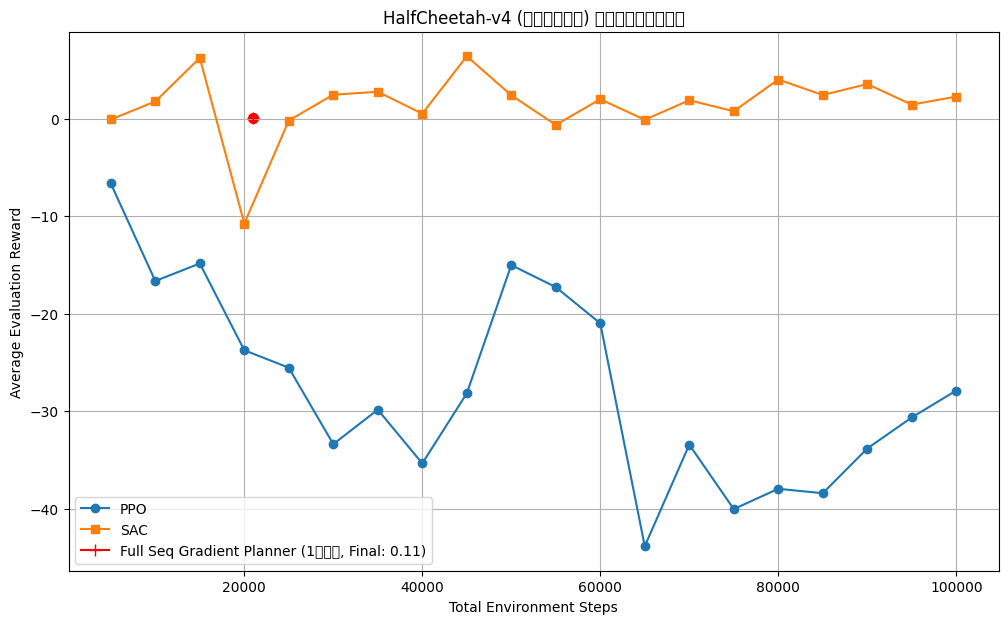

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 7))

# Plot PPO learning curve
if 'ppo_learning_curve' in locals() and ppo_learning_curve:
    ppo_steps = list(ppo_learning_curve.keys())
    ppo_rewards = list(ppo_learning_curve.values())
    plt.plot(ppo_steps, ppo_rewards, label='PPO', marker='o')

# Plot SAC learning curve
if 'sac_learning_curve' in locals() and sac_learning_curve:
    sac_steps = list(sac_learning_curve.keys())
    sac_rewards = list(sac_learning_curve.values())
    plt.plot(sac_steps, sac_rewards, label='SAC', marker='s')

# Plot Full Sequence Gradient Planner's learning curve as a step function
if 'full_grad_learning_curve' in locals() and full_grad_learning_curve:
    # キーが昇順にソートされていることを確認
    full_steps = sorted(list(full_grad_learning_curve.keys()))
    full_rewards = [full_grad_learning_curve[step] for step in full_steps]

    # 値がある場合のみグラフを描画
    if full_rewards:
        # 階段状のグラフを描画
        plt.step(full_steps, full_rewards, where='post', color='r', linestyle='-',
                marker='+', markersize=8, label=f'Full Seq Gradient Planner (1回計画, Final: {full_rewards[-1]:.2f})')

        # 各ポイントをプロット
        plt.scatter(full_steps, full_rewards, color='r', s=50)

plt.xlabel('Total Environment Steps')
plt.ylabel('Average Evaluation Reward')
plt.title('HalfCheetah-v4 (スパース報酬) における手法の比較')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 各モデルの最適方策を使って動画を記録・表示する
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
from IPython.display import HTML
import glob
import os
from IPython import display
import base64

# 動画を表示するヘルパー関数
def show_video(video_path):
    """
    指定したパスの動画をノートブック内に表示する
    """
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{base64.b64encode(video_file).decode()}"
    return HTML(f"""<video width=600 controls>
                    <source src="{video_url}" type="video/mp4">
                    </video>""")

# 動画を記録するためのディレクトリを作成
video_dir = "../videos/halfcheetah"
os.makedirs(video_dir, exist_ok=True)

# 各モデルについて最終的な方策を実行して動画を記録
models = {
    "Full_Sequence_Planner": full_grad_planner,
    "PPO": ppo_agent,
    "SAC": sac_agent_train
}

# 各モデルの評価と動画記録
for model_name, model in models.items():
    print(f"\n--- {model_name} の動画記録 ---")

    # 動画記録用のラッパー環境を作成 (render_mode="rgb_array"を指定)
    # スパース報酬ラッパーも適用
    video_env = RecordVideo(
        HalfCheetahFinalDistanceRewardWrapper(
            gym.make(ENV_ID, render_mode="rgb_array")
        ),
        video_folder=f"{video_dir}/{model_name}",
        name_prefix=f"{model_name}_episode",
        episode_trigger=lambda x: True
    )

    # エピソード実行
    state, _ = video_env.reset()
    done = False
    total_reward = 0

    # エージェントがresetメソッドを持っていれば呼び出し
    if hasattr(model, 'reset'):
        model.reset()

    # エピソード実行
    while not done:
        action = model.exploit(state)  # 最適方策での行動
        state, reward, terminated, truncated, _ = video_env.step(action)
        total_reward += reward
        done = terminated or truncated

    video_env.close()

    print(f"{model_name} の総報酬: {total_reward:.2f}")

    # 最新の動画ファイルを取得して表示
    video_files = sorted(glob.glob(f"{video_dir}/{model_name}/*.mp4"))
    if video_files:
        latest_video = video_files[-1]
        print(f"動画ファイル: {latest_video}")
        display.display(show_video(latest_video))
    else:
        print(f"警告: {model_name} の動画ファイルが見つかりませんでした。")

/home/yuki/my_ml_project/.venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/home/yuki/my_ml_project/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/yuki/my_ml_project/sparse-reward-comparison/videos/halfcheetah/Full_Sequence_Planner folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



--- Full_Sequence_Planner の動画記録 ---
Full_Sequence_Planner の総報酬: -0.04
動画ファイル: ../videos/halfcheetah/Full_Sequence_Planner/Full_Sequence_Planner_episode-episode-0.mp4
Full_Sequence_Planner の総報酬: -0.04
動画ファイル: ../videos/halfcheetah/Full_Sequence_Planner/Full_Sequence_Planner_episode-episode-0.mp4



--- PPO の動画記録 ---


/home/yuki/my_ml_project/.venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/home/yuki/my_ml_project/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/yuki/my_ml_project/sparse-reward-comparison/videos/halfcheetah/PPO folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


PPO の総報酬: -30.20
動画ファイル: ../videos/halfcheetah/PPO/PPO_episode-episode-0.mp4



--- SAC の動画記録 ---


/home/yuki/my_ml_project/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/yuki/my_ml_project/sparse-reward-comparison/videos/halfcheetah/SAC folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


SAC の総報酬: 2.16
動画ファイル: ../videos/halfcheetah/SAC/SAC_episode-episode-0.mp4


In [ ]:
# 現在の報酬閾値での学習が困難だった場合、閾値調整実験

# 報酬閾値を変更した場合の実験を行う関数
def experiment_with_different_threshold(threshold=3.0):
    print(f"報酬閾値 {threshold} での実験を開始...")

    # 新しい閾値で環境を作成
    adjusted_env = HalfCheetahSparseRewardWrapper(
        gym.make(ENV_ID),
        threshold=threshold
    )

    # データを収集
    print(f"ランダム行動で初期データを収集中...")
    adjusted_trajectories = collect_random_trajectories(adjusted_env, 10000)  # 少ないステップ数で試験

    # 動力学モデルと報酬モデルを初期化
    test_dynamics_model = DynamicsModel(state_dim=state_dim, action_dim=action_dim).to(device)
    test_reward_model = TerminalRewardModel(state_dim=state_dim, action_dim=action_dim).to(device)

    # テスト用のプランナーを設定
    test_planner = GradientPlannerAgent(
        test_dynamics_model, test_reward_model,
        action_dim=action_dim,
        action_high=adjusted_env.action_space.high,
        plan_horizon=GRAD_PLAN_HORIZON,
        num_iterations=GRAD_NUM_ITERATIONS,
        learning_rate=GRAD_LEARNING_RATE,
        use_full_sequence=True
    )

    # 短い実験で学習テスト
    test_learning_curve = train_world_models_iteratively(
        planner_agent=test_planner,
        env=adjusted_env,
        initial_trajectories=adjusted_trajectories,
        num_iterations=1,  # 1回だけの反復で試験
        steps_per_iteration=500,
        epochs_per_iteration=20,
        batch_size=256,
        learning_rate=WORLD_MODEL_LR,
        initial_random_steps=10000,
        new_data_ratio=0.8
    )

    # 最終評価を表示
    final_reward = list(test_learning_curve.values())[-1]
    print(f"報酬閾値 {threshold} での最終評価報酬: {final_reward:.2f}")

    return final_reward, test_learning_curve

# 必要に応じて異なる閾値での実験を実行
# threshold_results = {}
# for threshold in [1.0, 2.0, 3.0, 5.0, 7.0]:
#     reward, _ = experiment_with_different_threshold(threshold)
#     threshold_results[threshold] = reward
#
# # 結果の表示
# for threshold, reward in threshold_results.items():
#     print(f"閾値 {threshold}: 報酬 {reward:.2f}")